In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

In [2]:
import torch
import torch.nn as nn
import dynamic_nn_pt as dynn
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [3]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

In [4]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 50

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
train_size

60000

In [6]:
train_size // batch_size

1200

In [7]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)

In [8]:
train_label[0]

tensor(5)

In [9]:
dynet = dynn.Dynamic_Network(input_size, output_size, final_activation=None,
                             num_stat=5, num_std=250, decay_rate_std=0.03)
criterion = nn.CrossEntropyLoss()

In [10]:
### hyperparameters
num_add_neuron = 25#10
num_decay_steps = int(train_size/batch_size)*3
threshold_max = 0.1
threshold_min = 0.0001

train_epoch_min = 1
train_epoch_max = 5

In [11]:
dynet.tree.add_to_remove_ratio = 2.

In [12]:
num_decay_steps

3600

## Auto_Training

In [13]:
class AutoTrainer:
    
    def __init__(self):
        self.training_func = None
        self.adding_func = None
        self.pruning_func = None
        self.maintainance_func = None
        self.extra_func = None
        
    def loop(self, count = 15):
        cb = count
        while count>0:
            count-= 1
            self.adding_func()
            self.training_func()
            self.pruning_func()
            self.maintainance_func()
            if self.extra_func:
                self.extra_func()
            
            print(f"=====================")
            print(f"===LOOPS FINISHED :{cb-count} ===")
        self.training_func()

### when to stop training functionality

In [14]:
def update_coeff(num_iter, coeff0, coeff1, coeff2, coeff_opt, loss_list):
    if len(loss_list)<10: return np.array([0]), np.array([0]), float(coeff0.data[0])
    
    _t = torch.tensor(loss_list)
    _t = (_t - _t[-1])/(_t[0]-_t.min()) ## normalize to make first point at 1 and last at 0 
    _t = torch.clamp(_t, -1.1, 1.1)
    _x = torch.linspace(0, 1, steps=len(_t))
    
    for _ in range(num_iter):
        coeff_opt.zero_grad()
        _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

        _loss = ((_y - _t)**2).mean()
        _loss.backward()
        coeff_opt.step()

        coeff0.data = torch.clamp(coeff0.data, -20., 20.)
        coeff1.data = torch.clamp(coeff1.data, 0.7, 2.)
        coeff2.data = torch.clamp(coeff2.data, -0.2,0.1)
        
    if torch.isnan(coeff0.data[0]):
        coeff0.data[0] = 0.
        coeff1.data[0] = 0.
        coeff2.data[0] = 1. ## this gives signal
        
    _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

    return _x.numpy(), _t.numpy(), _y.data.numpy()

In [15]:
# a = torch.FloatTensor([1, 5, np.nan])
# if torch.isnan(a[0]):
#     print('___')

## Train Network dynamically

In [16]:
def shuffle_data():
    global train_data, train_label
    randidx = random.sample(range(len(train_label)), k=len(train_label))
    train_data = train_data[randidx]
    train_label = train_label[randidx]

In [17]:
## global variables
optimizer = None
coeff_opt = None

loss_all = []
accs_all = []
accs_test = []

In [18]:
def add_neurons_func():
    global optimizer
    dynet.add_neurons(num_add_neuron)
    dynet.print_network()    
    optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    return

In [19]:
def training_network_func():
    global optimizer, loss_all, accs_all
    
    coeff0 = torch.zeros(1, requires_grad=True)
    coeff1 = torch.zeros(1, requires_grad=True)
    coeff2 = torch.zeros(1, requires_grad=True)
    coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
    loss_list = []
    prev_loss = None
    beta_loss = (1000-1)/1000
    loss_ = []
    
    %matplotlib tk
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    

    steps_ = -1
    for epoch in range(train_epoch_max):
        
        train_acc = 0
        train_count = 0
#         print(epoch, train_size // batch_size)
#         loss_ = []
        shuffle_data()
        for index in range(train_size // batch_size):
            steps_ += 1
            
            train_x = train_data[index * batch_size:(index + 1) * batch_size]
            train_y = train_label[index * batch_size:(index + 1) * batch_size]

            dynet.decay_neuron_step()
            dynet.tree.std_loss = 0.    

            yout = dynet(train_x)
            loss = criterion(yout, train_y) + dynet.tree.decay_rate_std*dynet.tree.std_loss
            
            if steps_>100:
                prev_loss = (1-beta_loss)*float(loss)+beta_loss*prev_loss
                loss_list.append(prev_loss)
#                 loss_.append(float(loss))
#                 loss_list.append(float(loss))
            elif steps_ == 100:
                loss_.append(float(loss))
                prev_loss = np.mean(loss_)
                loss_ = []
            else:
                loss_.append(float(loss))
                    
            optimizer.zero_grad()
            loss.backward(retain_graph=False)
            optimizer.step()
            
            outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
#             targets = tnn.Logits.logit_to_index(train_y.data.cpu().numpy())
            targets = train_y.data.cpu().numpy()

            correct = (outputs == targets).sum()
            train_acc += correct
            train_count += len(outputs)
#             print(train_size)

#             if steps_%50 == 0 and steps_>100:
#                 loss = np.mean(loss_)
#                 loss_ = []
#                 loss_list.append(loss)
            
            if steps_%100 == 0 and steps_>0:
                if len(loss_list)>0:
                    max_indx = np.argmax(loss_list)
                    loss_list = loss_list[max_indx:]
#                 loss_all.append(float(loss))
                
                _x, _t, _y = update_coeff(50, coeff0, coeff1, coeff2, coeff_opt, loss_list)
                _c = float(coeff0.data[0])
    #             if coeff2.data[0] > 0.5: ## this is a signal to reset optimizer
                coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
                print(f'ES: {epoch}:{steps_}, Loss:{float(loss)}, coeff:{_c}, Acc:{correct/len(outputs)*100}%')

                ax.clear()
                if len(_x)>0:
                    ax.plot(_x, _t, c='c')
                    ax.plot(_x, _y, c='m')
                    
                ax2.clear()
                if len(accs_all)>0:
                    acc_tr = accs_all
                    if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                    ax2.plot(acc_tr, label="train")
                    
                    ymin, ymax = ax2.get_ylim()
#                     print()
                    ax2.text(0, 0.1*ymin+0.9*ymax, f"TR:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                    acc_tr = accs_test
                    if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                    ax2.plot(acc_tr, label="test")
                    ax2.text(0, 0.2*ymin+0.8*ymax, f"TE:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                    ax2.legend()

                
                fig.canvas.draw()
                plt.pause(0.01)
                print("\n")

                if _c < -5 and epoch>train_epoch_min: 
                    break
                    
        accs_all.append(train_acc/train_count*100.)
        with torch.no_grad():
            yout = dynet.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
            correct = (outputs == np.array(test_label_)).sum()
            accs_test.append(correct/len(test_label_)*100)
    plt.close()
    return

In [20]:
def pruning_func():
    global optimizer
    optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    
    
    dynet.start_computing_significance()

#     steps_ = 0
#     breakall = True
    for index in range(train_size // batch_size):

        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        dynet.tree.std_loss = 0.    

        yout = dynet(train_x)

        yout.backward(gradient=torch.ones_like(yout))
        optimizer.zero_grad()
            
#             steps_+=1


    dynet.finish_computing_significance()
    dynet.identify_removable_neurons(num=None,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)
    num_remove = dynet.decay_neuron_start(decay_steps=num_decay_steps)
    if num_remove > 0:
        print(f"pruning {num_remove} neurons.")
        
        %matplotlib tk    
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        loss_list = []
        steps_ = -1
        train_acc = 0
        train_count = 0
        breakall=False
        for epoch in range(train_epoch_max):
            loss_ = []
            shuffle_data()
            for index in range(train_size // batch_size):
                steps_ += 1
                train_x = train_data[index * batch_size:(index + 1) * batch_size]
                train_y = train_label[index * batch_size:(index + 1) * batch_size]

                dynet.decay_neuron_step()
                dynet.tree.std_loss = 0.    

                yout = dynet(train_x)
                loss = criterion(yout, train_y) + dynet.tree.decay_rate_std*dynet.tree.std_loss

                loss_.append(float(loss))

                optimizer.zero_grad()
                loss.backward(retain_graph=False)
                optimizer.step()

                outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
#                 targets = tnn.Logits.logit_to_index(train_y.data.cpu().numpy())
                targets = train_y.data.cpu().numpy()
                correct = (outputs == targets).sum()
                train_acc += correct
                train_count += len(outputs)

                dynet.decay_neuron_step()
                
                if steps_%50 == 0 and steps_>0:
                    loss = np.mean(loss_)
                    loss_ = []
                    loss_list.append(loss)
                
                if steps_%100 == 0 and steps_>0:
                    
                    print(f'ES: {epoch}:{steps_}, Loss:{float(loss)}, Acc:{correct/len(outputs)*100}%')
                    ax.clear()

                    out = (yout.data.numpy()>0.5).astype(int)
                    ax.plot(loss_list)
                    
                    ax2.clear()
                    if len(accs_all)>0:
                        acc_tr = accs_all
                        if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                        ax2.plot(acc_tr, label="train")

                        ymin, ymax = ax2.get_ylim()
                        ax2.text(0, 0.1*ymin+0.9*ymax, f"TR:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                        acc_tr = accs_test
                        if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                        ax2.plot(acc_tr, label="test")
                        ax2.text(0, 0.2*ymin+0.8*ymax, f"TE:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                        ax2.legend()
                    
                    fig.canvas.draw()
                    plt.pause(0.01)
                    print("\n")
                    
                if steps_>num_decay_steps+5: breakall=True
                if breakall: break
            if breakall: break
                
        accs_all.append(train_acc/train_count*100.)
        with torch.no_grad():
            yout = dynet.forward(test_data)
            outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
            correct = (outputs == np.array(test_label_)).sum()
            accs_test.append(correct/len(test_label_)*100)
        plt.close()
    return

In [21]:
def maintain_network():
    dynet.compute_del_neurons()
    dynet.maintain_network()
    dynet.print_network()
    return

# Set all functions and begin automated loop

In [22]:
trainer = AutoTrainer()

In [23]:
trainer.adding_func = add_neurons_func
trainer.training_func = training_network_func
trainer.pruning_func = pruning_func
trainer.maintainance_func = maintain_network

In [24]:
trainer.loop(20)

784
├────┐
│    25
├────┘
│
10
ES: 0:100, Loss:2.0121138095855713, coeff:0.0, Acc:52.0%


ES: 0:200, Loss:1.6917856931686401, coeff:0.36403363943099976, Acc:70.0%


ES: 0:300, Loss:1.4174193143844604, coeff:0.27514204382896423, Acc:70.0%


ES: 0:400, Loss:1.0787818431854248, coeff:0.525455117225647, Acc:92.0%


ES: 0:500, Loss:1.0042141675949097, coeff:0.4100084602832794, Acc:74.0%


ES: 0:600, Loss:0.8123981952667236, coeff:0.18545693159103394, Acc:90.0%


ES: 0:700, Loss:0.7028710842132568, coeff:0.32383981347084045, Acc:90.0%


ES: 0:800, Loss:0.70351243019104, coeff:0.2540785074234009, Acc:92.0%


ES: 0:900, Loss:0.7567180395126343, coeff:0.1937883347272873, Acc:86.0%


ES: 0:1000, Loss:0.5574083924293518, coeff:0.1313111037015915, Acc:90.0%


ES: 0:1100, Loss:0.6266211867332458, coeff:0.07441993057727814, Acc:84.0%


ES: 1:1200, Loss:0.6620761156082153, coeff:-0.0006279926747083664, Acc:80.0%


ES: 1:1300, Loss:0.4375350773334503, coeff:-0.05639691650867462, Acc:90.0%


ES: 1:1400



ES: 2:2700, Loss:0.2586486339569092, coeff:0.29086732864379883, Acc:92.0%


ES: 2:2800, Loss:0.1906503438949585, coeff:0.4545871615409851, Acc:96.0%


ES: 2:2900, Loss:0.2127613127231598, coeff:0.35727477073669434, Acc:94.0%


ES: 2:3000, Loss:0.12601642310619354, coeff:-0.5878986120223999, Acc:100.0%


ES: 2:3100, Loss:0.3797623813152313, coeff:0.3215651512145996, Acc:90.0%


ES: 2:3200, Loss:0.28130796551704407, coeff:0.028121139854192734, Acc:90.0%


ES: 2:3300, Loss:0.1903688907623291, coeff:-0.28620487451553345, Acc:94.0%


ES: 2:3400, Loss:0.22062407433986664, coeff:0.007868543267250061, Acc:94.0%


ES: 2:3500, Loss:0.24817311763763428, coeff:0.13738344609737396, Acc:90.0%


ES: 3:3600, Loss:0.4468940794467926, coeff:0.04775599390268326, Acc:88.0%


ES: 3:3700, Loss:0.39921078085899353, coeff:0.15038847923278809, Acc:90.0%


ES: 3:3800, Loss:0.18739880621433258, coeff:0.14588689804077148, Acc:96.0%


ES: 3:3900, Loss:0.31813856959342957, coeff:0.279738187789917, Acc:92.0%


ES:



ES: 4:5100, Loss:0.27945736050605774, coeff:0.25399598479270935, Acc:92.0%


ES: 4:5200, Loss:0.4086168110370636, coeff:-0.00042880699038505554, Acc:90.0%


ES: 4:5300, Loss:0.058874472975730896, coeff:0.45555317401885986, Acc:100.0%


ES: 4:5400, Loss:0.35568562150001526, coeff:0.3132244348526001, Acc:92.0%


ES: 4:5500, Loss:0.14922432601451874, coeff:0.03368338197469711, Acc:94.0%


ES: 4:5600, Loss:0.11683036386966705, coeff:0.26381897926330566, Acc:100.0%


ES: 4:5700, Loss:0.1998438835144043, coeff:0.2169150710105896, Acc:96.0%


ES: 4:5800, Loss:0.1305759698152542, coeff:0.18602433800697327, Acc:98.0%


ES: 4:5900, Loss:0.21199281513690948, coeff:0.14992932975292206, Acc:92.0%


pruning 13 neurons.
ES: 0:100, Loss:0.13923322200775146, Acc:94.0%


ES: 0:200, Loss:0.18949889905750752, Acc:98.0%


ES: 0:300, Loss:0.17524112917482854, Acc:98.0%


ES: 0:400, Loss:0.1696839714795351, Acc:100.0%


ES: 0:500, Loss:0.17010087341070176, Acc:96.0%


ES: 0:600, Loss:0.162870841473341, Acc



ES: 1:2200, Loss:0.1490829671919346, Acc:96.0%


ES: 1:2300, Loss:0.11835122652351857, Acc:98.0%


ES: 2:2400, Loss:0.13499243557453156, Acc:96.0%


ES: 2:2500, Loss:0.1357480787485838, Acc:98.0%


ES: 2:2600, Loss:0.11970772214233875, Acc:96.0%


ES: 2:2700, Loss:0.11140926495194435, Acc:90.0%


ES: 2:2800, Loss:0.13977038830518723, Acc:100.0%


ES: 2:2900, Loss:0.1241482425481081, Acc:96.0%


ES: 2:3000, Loss:0.1262692829221487, Acc:100.0%


ES: 2:3100, Loss:0.12381768107414245, Acc:94.0%


ES: 2:3200, Loss:0.12555874340236187, Acc:98.0%


ES: 2:3300, Loss:0.13985518738627434, Acc:100.0%


ES: 2:3400, Loss:0.13045408703386785, Acc:96.0%


ES: 2:3500, Loss:0.11816683121025562, Acc:98.0%


ES: 3:3600, Loss:0.21004469692707062, Acc:94.0%


784
├────┐
│    53
│    ├────┐
│    │    6
│    ├────┘
├────┘
│
10
===LOOPS FINISHED :4 ===
784
├────┐
│    ├────┐
│    │    7
│    ├────┘
│    66
│    ├────┐
│    │    11
│    ├────┘
├────┘
│
10
ES: 0:100, Loss:0.12072132527828217, coeff:0.0, Acc:9



ES: 0:1100, Loss:0.21712711453437805, coeff:-2.009890556335449, Acc:94.0%


ES: 1:1200, Loss:0.05450423061847687, coeff:-4.408189296722412, Acc:100.0%


ES: 1:1300, Loss:0.0944499671459198, coeff:-2.180691957473755, Acc:98.0%


ES: 1:1400, Loss:0.15890879929065704, coeff:-8.812644004821777, Acc:98.0%


ES: 1:1500, Loss:0.06678427755832672, coeff:-0.6243168115615845, Acc:100.0%


ES: 1:1600, Loss:0.10390371084213257, coeff:0.5568860769271851, Acc:98.0%


ES: 1:1700, Loss:0.24965010583400726, coeff:0.9637954235076904, Acc:92.0%


ES: 1:1800, Loss:0.10078185796737671, coeff:0.2581605315208435, Acc:98.0%


ES: 1:1900, Loss:0.15924648940563202, coeff:0.7906938195228577, Acc:98.0%


ES: 1:2000, Loss:0.13438205420970917, coeff:0.1841025948524475, Acc:96.0%


ES: 1:2100, Loss:0.09696979820728302, coeff:-0.771547257900238, Acc:98.0%


ES: 1:2200, Loss:0.10172775387763977, coeff:-2.2165064811706543, Acc:98.0%


ES: 1:2300, Loss:0.09309646487236023, coeff:-0.8429086804389954, Acc:100.0%


ES: 2



ES: 2:3300, Loss:0.05944681167602539, coeff:-0.5465207099914551, Acc:98.0%


ES: 2:3400, Loss:0.06607821583747864, coeff:-1.1582529544830322, Acc:100.0%


ES: 2:3500, Loss:0.04449497163295746, coeff:-0.7326788902282715, Acc:100.0%


ES: 3:3600, Loss:0.06323786079883575, coeff:-1.854399561882019, Acc:100.0%


ES: 3:3700, Loss:0.11980602890253067, coeff:-0.8840481042861938, Acc:98.0%


ES: 3:3800, Loss:0.056690704077482224, coeff:-0.972848653793335, Acc:98.0%


ES: 3:3900, Loss:0.11338686943054199, coeff:-0.6744797229766846, Acc:96.0%


ES: 3:4000, Loss:0.07998398691415787, coeff:-0.7732658386230469, Acc:96.0%


ES: 3:4100, Loss:0.1170448586344719, coeff:-0.758493185043335, Acc:96.0%


ES: 3:4200, Loss:0.10049816966056824, coeff:-1.158923625946045, Acc:98.0%


ES: 3:4300, Loss:0.07803061604499817, coeff:-0.6210775375366211, Acc:98.0%


ES: 3:4400, Loss:0.12658704817295074, coeff:-0.5668283104896545, Acc:98.0%


ES: 3:4500, Loss:0.032649826258420944, coeff:-0.972811222076416, Acc:100.0%



ES: 4:5400, Loss:0.05334952101111412, coeff:0.30321645736694336, Acc:100.0%


ES: 4:5500, Loss:0.03516729176044464, coeff:0.2524831295013428, Acc:100.0%


ES: 4:5600, Loss:0.03252420574426651, coeff:0.28314799070358276, Acc:100.0%


ES: 4:5700, Loss:0.04030877351760864, coeff:-0.23998408019542694, Acc:100.0%


ES: 4:5800, Loss:0.04518790543079376, coeff:0.31896141171455383, Acc:98.0%


ES: 4:5900, Loss:0.030674170702695847, coeff:0.14849887788295746, Acc:100.0%


pruning 13 neurons.
ES: 0:100, Loss:0.05136334985494614, Acc:98.0%


ES: 0:200, Loss:0.06580684468150139, Acc:100.0%


ES: 0:300, Loss:0.06440679531544447, Acc:98.0%


ES: 0:400, Loss:0.06679240372031928, Acc:98.0%


ES: 0:500, Loss:0.07485473476350307, Acc:100.0%


ES: 0:600, Loss:0.07572996199131012, Acc:98.0%


ES: 0:700, Loss:0.0755689051002264, Acc:98.0%


ES: 0:800, Loss:0.07946503758430482, Acc:100.0%


ES: 0:900, Loss:0.07852200157940388, Acc:98.0%


ES: 0:1000, Loss:0.07496329434216023, Acc:96.0%


ES: 0:1100, Loss:



ES: 1:2100, Loss:0.05522292777895928, Acc:96.0%


ES: 1:2200, Loss:0.044975575394928455, Acc:98.0%


ES: 1:2300, Loss:0.047793559692800046, Acc:98.0%


ES: 2:2400, Loss:0.022942155599594116, Acc:100.0%


ES: 2:2500, Loss:0.052116097733378414, Acc:98.0%


ES: 2:2600, Loss:0.044695159159600734, Acc:98.0%


ES: 2:2700, Loss:0.056494516879320146, Acc:98.0%


ES: 2:2800, Loss:0.04810482408851385, Acc:100.0%


ES: 2:2900, Loss:0.050919660478830335, Acc:98.0%


ES: 2:3000, Loss:0.04520082652568817, Acc:100.0%


ES: 2:3100, Loss:0.0486021626368165, Acc:100.0%


ES: 2:3200, Loss:0.05185865577310324, Acc:98.0%


ES: 2:3300, Loss:0.05303948484361172, Acc:98.0%


ES: 2:3400, Loss:0.05335437510162592, Acc:100.0%


ES: 2:3500, Loss:0.04663373686373234, Acc:100.0%


ES: 3:3600, Loss:0.0779251903295517, Acc:98.0%


784
├────┐
│    ├────┐
│    │    6
│    ├────┘
│    81
│    ├────┐
│    │    ├────┐
│    │    │    2
│    │    ├────┘
│    │    30
│    │    ├────┐
│    │    │    1
│    │    ├────┘
│    



ES: 0:200, Loss:0.03292454779148102, coeff:-6.317742347717285, Acc:100.0%


ES: 0:300, Loss:0.022922685369849205, coeff:-6.317742347717285, Acc:100.0%


ES: 0:400, Loss:0.05142863094806671, coeff:1.3824472427368164, Acc:100.0%


ES: 0:500, Loss:0.03365345299243927, coeff:1.3824472427368164, Acc:100.0%


ES: 0:600, Loss:0.025398917496204376, coeff:1.3824472427368164, Acc:100.0%


ES: 0:700, Loss:0.04003423452377319, coeff:-4.328896999359131, Acc:100.0%


ES: 0:800, Loss:0.04733901098370552, coeff:-4.328896999359131, Acc:98.0%


ES: 0:900, Loss:0.030615516006946564, coeff:-15.475177764892578, Acc:100.0%


ES: 0:1000, Loss:0.02213170751929283, coeff:0.07744581997394562, Acc:100.0%


ES: 0:1100, Loss:0.03149138018488884, coeff:1.2055805921554565, Acc:100.0%


ES: 1:1200, Loss:0.043378494679927826, coeff:1.2055805921554565, Acc:100.0%


ES: 1:1300, Loss:0.03368280455470085, coeff:-1.2837785482406616, Acc:100.0%


ES: 1:1400, Loss:0.029452189803123474, coeff:0.13823683559894562, Acc:100.0%

ES: 1:1900, Loss:0.014120887033641338, coeff:0.28994059562683105, Acc:100.0%


ES: 1:2000, Loss:0.03936931863427162, coeff:0.2311576008796692, Acc:98.0%


ES: 1:2100, Loss:0.01765700988471508, coeff:-0.24528786540031433, Acc:100.0%


ES: 1:2200, Loss:0.012627055868506432, coeff:-0.05681741610169411, Acc:100.0%


ES: 1:2300, Loss:0.011452402919530869, coeff:-0.17109651863574982, Acc:100.0%


ES: 2:2400, Loss:0.018982762470841408, coeff:-0.1892717331647873, Acc:100.0%


ES: 2:2500, Loss:0.017173388972878456, coeff:-0.06481432169675827, Acc:100.0%


ES: 2:2600, Loss:0.0329667367041111, coeff:0.03097606636583805, Acc:100.0%


ES: 2:2700, Loss:0.022147521376609802, coeff:-0.10786329209804535, Acc:100.0%


ES: 2:2800, Loss:0.01723075844347477, coeff:-0.195362389087677, Acc:100.0%


ES: 2:2900, Loss:0.023029297590255737, coeff:-0.12975436449050903, Acc:100.0%


ES: 2:3000, Loss:0.035210102796554565, coeff:-0.000778876943513751, Acc:98.0%


ES: 2:3100, Loss:0.022578023374080658, coeff:-0.08763



ES: 3:3600, Loss:0.013801145367324352, coeff:-0.8187886476516724, Acc:100.0%


ES: 3:3700, Loss:0.008385452441871166, coeff:-0.36562249064445496, Acc:100.0%


ES: 3:3800, Loss:0.02905936725437641, coeff:-0.57395339012146, Acc:100.0%


ES: 3:3900, Loss:0.02136099897325039, coeff:-0.8692686557769775, Acc:100.0%


ES: 3:4000, Loss:0.021021701395511627, coeff:-0.6270634531974792, Acc:100.0%


ES: 3:4100, Loss:0.009380866773426533, coeff:-0.650615394115448, Acc:100.0%


ES: 3:4200, Loss:0.01145622506737709, coeff:-0.9427069425582886, Acc:100.0%


ES: 3:4300, Loss:0.027997899800539017, coeff:-0.7103537917137146, Acc:100.0%


ES: 3:4400, Loss:0.014288030564785004, coeff:-0.9985823631286621, Acc:100.0%


ES: 3:4500, Loss:0.011328723281621933, coeff:-0.7551904916763306, Acc:100.0%


ES: 3:4600, Loss:0.019064679741859436, coeff:-0.7965244650840759, Acc:100.0%


ES: 3:4700, Loss:0.01821817085146904, coeff:-0.8256491422653198, Acc:100.0%


ES: 4:4800, Loss:0.017112791538238525, coeff:-0.89905899



ES: 4:5300, Loss:0.03177713230252266, coeff:-0.11669239401817322, Acc:100.0%


ES: 4:5400, Loss:0.01095658354461193, coeff:-0.3385585844516754, Acc:100.0%


ES: 4:5500, Loss:0.007529299706220627, coeff:-0.633454442024231, Acc:100.0%


ES: 4:5600, Loss:0.01172899454832077, coeff:-0.42039716243743896, Acc:100.0%


ES: 4:5700, Loss:0.01640433259308338, coeff:-0.6393526196479797, Acc:100.0%


ES: 4:5800, Loss:0.021957598626613617, coeff:-0.2669757604598999, Acc:100.0%


ES: 4:5900, Loss:0.018698999658226967, coeff:-0.39342546463012695, Acc:100.0%


pruning 13 neurons.
ES: 0:100, Loss:0.020337939690798522, Acc:100.0%


ES: 0:200, Loss:0.03237047482281923, Acc:100.0%


ES: 0:300, Loss:0.042933727204799654, Acc:100.0%


ES: 0:400, Loss:0.04953274041414261, Acc:100.0%


ES: 0:500, Loss:0.053412257581949237, Acc:100.0%


ES: 0:600, Loss:0.05585576884448528, Acc:100.0%


ES: 0:700, Loss:0.056527611538767814, Acc:100.0%


ES: 0:800, Loss:0.059598083943128585, Acc:100.0%


ES: 0:900, Loss:0.0599

TclError: invalid command name "."

In [32]:
torch.randn(100, 0).matmul(torch.randn(21, 0).t()).shape

torch.Size([100, 21])

In [25]:
dynet.print_network()

784
├────┐
│    ├────┐
│    │    16
│    ├────┘
│    100
│    ├────┐
│    │    ├────┐
│    │    │    10
│    │    ├────┘
│    │    54
│    │    ├────┐
│    │    │    13
│    │    ├────┘
│    ├────┘
├────┘
│
10


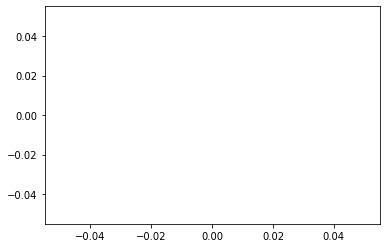

In [26]:
%matplotlib inline
plt.plot(loss_all)

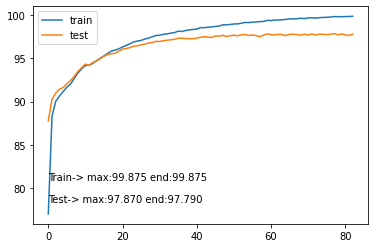

In [27]:
plt.plot(accs_all, label="train")
plt.plot(accs_test, label="test")
ymin, ymax = plt.gca().get_ylim()
plt.text(0, 0.8*ymin+0.2*ymax, f"Train-> max:{max(accs_all):.3f} end:{accs_all[-1]:.3f}")
plt.text(0, 0.9*ymin+0.1*ymax, f"Test-> max:{max(accs_test):.3f} end:{accs_test[-1]:.3f}")
                    
plt.legend()
plt.savefig("files/03_noisynas_v0_softmax_5.png")

In [28]:
max(accs_test)

97.87

In [29]:
max(accs_all)

99.875

In [30]:
np.argmax(accs_test)

77

In [31]:
len(accs_test)

83